In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.linear_model   import Lasso,Ridge

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster,ForecastingPipeline
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender
from sktime.forecasting.model_selection import temporal_train_test_split

from hyperopt import fmin, hp, tpe
from hyperopt import SparkTrials, STATUS_OK, Trials

from sktime.split import ExpandingGreedySplitter

import warnings

In [3]:
pdf = pd.read_csv("../../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  
pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])
pdf.index = pd.period_range(start=pdf.index[0], end= pdf.index[-1], freq="M")

In [59]:
#simple splits
# split = len(pdf)-12
#y_train, y_test = pdf.iloc[:split], pdf.iloc[split:]
# y_train, y_test = temporal_train_test_split(pdf)

# idx = pd.period_range(start=y_train.index[0], end= y_train.index[-1], freq="M")
# y_train = pd.Series(y_train.y.values, index=idx)

In [4]:
#Let's add a bit of hyperparameter optimization

def hyperoptimize_forecaster(forecaster,search_space,pdf,splits,max_evals=30,timeout=5*60):
    "Wrapper around hyperparameter tuning of any forecaster."

    def set_forecaster(forecaster):
        def train(params):
            """
            Main training function which we pass to Hyperopt.It takes in hyperparameter settings,
            fits a model based on those settings and evaluates the model, and returns the loss.
            """
            f = forecaster(**params)
            metrics = []

            for split in splits:
                y_train = pdf.iloc[split[0]]
                y_test  = pdf.iloc[split[1]]            
                idx = pd.period_range(start=y_test.index[0], end= y_test.index[-1], freq="M")
                prediction = f.fit_predict(y_train, fh=ForecastingHorizon(idx, is_relative=False))
                metrics.append(mean_absolute_error(y_test,prediction))
            return {"loss": np.median(metrics), "status": STATUS_OK, "Trained_Model": f}
        
        return train
    
    train_forecaster=set_forecaster(forecaster)
    algorithm = tpe.suggest #Tree of Parzen Estimators, a Bayesian method
    hyperTrials = Trials()
    hyperparameters = fmin(
                           fn=train_forecaster,
                           space=search_space,
                           algo=algorithm,
                           trials=hyperTrials,
                           max_evals=max_evals,
                           timeout=timeout   #seconds
                           ) 
    bestModel = hyperTrials.results[np.argmin([r["loss"] for r in hyperTrials.results])]["Trained_Model"]
    return bestModel

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

16:39:29 - cmdstanpy - INFO - Chain [1] start processing

16:39:30 - cmdstanpy - INFO - Chain [1] done processing

16:39:30 - cmdstanpy - INFO - Chain [1] start processing

16:39:30 - cmdstanpy - INFO - Chain [1] done processing

16:39:31 - cmdstanpy - INFO - Chain [1] start processing

16:39:31 - cmdstanpy - INFO - Chain [1] done processing

16:39:31 - cmdstanpy - INFO - Chain [1] start processing

16:39:32 - cmdstanpy - INFO - Chain [1] done processing



 50%|█████     | 1/2 [00:02<00:02,  2.77s/trial, best loss: 3.8706299985604504]

16:39:32 - cmdstanpy - INFO - Chain [1] start processing

16:39:33 - cmdstanpy - INFO - Chain [1] done processing

16:39:33 - cmdstanpy - INFO - Chain [1] start processing

16:39:33 - cmdstanpy - INFO - Chain [1] done processing

16:39:34 - cmdstanpy - INFO - Chain [1] start processing

16:39:34 - cmdstanpy - INFO - Chain [1] done processing

16:39:34 - cmdstanpy - INFO - Chain [1] start processing

16:39:35 - cmdstanpy - INFO - Chain [1] done processing



100%|██████████| 2/2 [00:05<00:00,  2.94s/trial, best loss: 3.8706299985604504]


In [ ]:
warnings.filterwarnings('ignore')

prophet_search_space = {
"seasonality_mode":        hp.choice("seasonality_mode",["multiplicative", "additive"]),
#"add_country_holidays":    hp.choice("holidays",[None,{'country_name': 'Switzerland'}]),
"changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),  # according to recom. same as [0.001,0.5]
"seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),    # according to recom. same as [0.001, 10]
#"holidays_prior_scale":    hp.loguniform("holidays_prior_scale", -6.9, 2.3),       # according to recom. same as [0.001, 10]
"changepoint_range":       hp.uniform("changepoint_range", 0.8, 0.95)              # optional according to docs, default = 0.8
}

exp_search_space= {
                    "trend":        hp.choice("trend",["additive", "multiplicative", None]),
                    "seasonal":     hp.choice("seasonal",["additive", "multiplicative", None]),
                    "damped_trend": hp.choice("damped_trend",[True, False]),
                    "sp": 12
                }

theta_search_space = {"deseasonalize": hp.choice("deseasonalize",[True, False]),
                      "sp": 12}


splitter = ExpandingGreedySplitter(test_size=12, folds=4)
splits = list(splitter.split(pdf))
forecasters = [Prophet,ExponentialSmoothing,ThetaForecaster]
spaces = [prophet_search_space,exp_search_space,theta_search_space]


best_models = []
for forecaster,space in zip(forecasters,spaces):
    best_models.append(hyperoptimize_forecaster(forecaster,space,pdf,splits,max_evals=10))


In [19]:
#for this case i need to write a function which does the unpacking of the paramerts.
# Such a forecaster can be built. Not sure how to do that but that should also be implemented in sktime repo. 
# Will have a look. For the moment this does not work. 

arima = TransformedTargetForecaster([
                                    ("detrend",         Detrender(TrendForecaster(Lasso()))),
                                    ("deseasonalize",   Deseasonalizer()),
                                    ("forecast",        ARIMA())  
                                    ])


# param_grid = {
#     "deseasonalizer__model": ["multiplicative", "additive"],
#     "deseasonalizer__sp": 12,
# }

# hyperoptimize_forecaster(arima,param_grid,pdf,splits,max_evals=10)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: 'TransformedTargetForecaster' object is not callable



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]


TypeError: 'TransformedTargetForecaster' object is not callable

In [61]:
warnings.filterwarnings('ignore')
arima = TransformedTargetForecaster([
                                    ("detrend",         Detrender(forecaster=TrendForecaster(Lasso()))),
                                    ("deseasonalize",   Deseasonalizer(model="additive", sp=12)),
                                    ("forecast",        ARIMA())  
                                    ])




forecasters= {"theta":theta,
              "prophet":prophet,
              "arima with lasso-detrend": arima,
              "exp": exp,
              }

last_train_test = {}                
one_year_predictions = {}
one_year_metrics = {}

#let's measure the performance for a one year prediction for each split and save it.
for i,split in enumerate(splits):
    y_train_split = pdf.iloc[split[0]]
    y_test_split = pdf.iloc[split[1]]
    if i==0: 
        one_year_metrics = {name:[] for name in forecasters.keys()}

    for name,forecaster in forecasters.items():
        forecaster.fit(y_train_split)
        #one year ahead prediction   
        idx = pd.period_range(start=y_test_split.index[0], end= y_test_split.index[-1], freq="M")
        horizon = ForecastingHorizon(idx, is_relative=False)
        one_year  = forecaster.predict(fh=horizon)
        one_year_metrics[name].append(mean_absolute_error(y_test_split.values,one_year.values))

        if i == len(splits)-1:
            one_year_predictions[name] = one_year.y
            last_train_test["last_split"] = (y_train_split,y_test_split)

15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:51 - cmdstanpy - INFO - Chain [1] done processing
15:19:51 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:52 - cmdstanpy - INFO - Chain [1] done processing
15:19:53 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
best_prophet

NameError: name 'best_prophet' is not defined

In [69]:
for name in one_year_metrics.keys():
    print(name,":",np.round_(one_year_metrics[name],2))

theta : [5.75 4.58 2.73 2.75]
prophet : [5.05 3.53 4.77 2.69]
arima with lasso-detrend : [5.27 2.99 3.03 1.55]
exp : [6.27 3.99 2.67 2.88]


In [63]:
#create an optimally weighted ensemble
from scipy.optimize import minimize

df = pd.DataFrame(one_year_predictions)
y_test = last_train_test["last_split"][1].values


def loss_func(weights):    
    fc = np.sum(df*np.array(weights),axis=1)
    return mean_squared_error(y_test,fc)


opt_weights = minimize(loss_func, 
                       x0=[1/len(df.columns)]*len(df.columns),
                       constraints=[{'type':'eq','fun':lambda w: 1-sum(w)}], 
                       method='SLSQP', 
                       bounds=[(0.0,1.0)]*len(df.columns),
                       options={'ftol':1e-10}
                       )

#create a dataframe with the optimized weights 
opt_weights_df = pd.DataFrame(opt_weights.x,index=df.columns,columns=['opt_weight'])

weights_dict = opt_weights_df["opt_weight"].to_dict()
df["ensemble"] =  df[weights_dict.keys()].mul(weights_dict.values()).sum(axis=1)

In [65]:
#compute the mae of the ensemble
print("ensemble mae:",mean_absolute_error(y_test,df["ensemble"].values))

ensemble mae: 1.5464182463348994


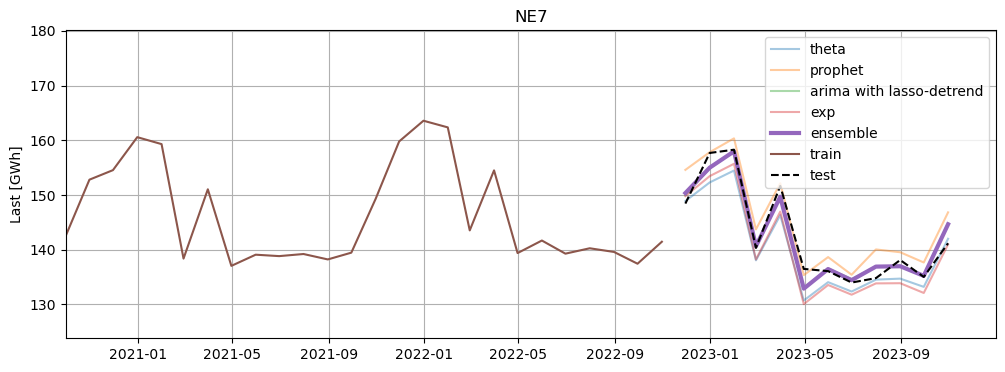

In [64]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

for name in one_year_predictions.keys():
    axes.plot(one_year_predictions[name].index.to_timestamp(freq="M"), one_year_predictions[name].values, label=name, alpha=0.4)

axes.plot(df["ensemble"].index.to_timestamp(freq="M"), df["ensemble"].values, label="ensemble", linewidth=3)

axes.plot(last_train_test["last_split"][0].index.to_timestamp(freq="M"), 
          last_train_test["last_split"][0].values, label="train")
axes.plot(last_train_test["last_split"][1].index.to_timestamp(freq="M"), 
          last_train_test["last_split"][1].values, label="test", color="black",linestyle="--")

axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")

axes.set_xlim([pd.Timestamp(2020,10,1),pd.Timestamp(2023,12,31)])
axes.grid()
plt.show()

In [ ]:
#Next: 
# Test the windowed approach with a fixed window size, meaning a non expanding window.
# Add hyperopt for the models. Take hyperparams which are best on the average or the median of the splits.